In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import datetime as dt
from sklearn.decomposition import PCA
!pip install haversine
from haversine import haversine

from google.colab import files
uploaded = files.upload()

Saving sales_data_sample.csv to sales_data_sample (1).csv


In [25]:
# Load the dataset
df = pd.read_csv('./sales_data_sample.csv', encoding='unicode_escape')

# Check first few rows of the dataset
df.head()


,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [26]:
# Drop irrelevant columns
to_drop = ['ADDRESSLINE1', 'ADDRESSLINE2', 'STATE', 'POSTALCODE', 'PHONE']
df = df.drop(to_drop, axis=1)

# Check for missing values
df.isnull().sum()


,0
ORDERNUMBER,0
QUANTITYORDERED,0
PRICEEACH,0
ORDERLINENUMBER,0
SALES,0
ORDERDATE,0
STATUS,0
QTR_ID,0
MONTH_ID,0
YEAR_ID,0


In [27]:
# Convert ORDERDATE to datetime
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'], errors='coerce')

# Drop rows where ORDERDATE is NaT (Not a Time)
df = df.dropna(subset=['ORDERDATE'])

# Check data types and ensure ORDERDATE is in datetime format
df.dtypes


,0
ORDERNUMBER,int64
QUANTITYORDERED,int64
PRICEEACH,float64
ORDERLINENUMBER,int64
SALES,float64
ORDERDATE,datetime64[ns]
STATUS,object
QTR_ID,int64
MONTH_ID,int64
YEAR_ID,int64


In [28]:
# Create RFM (Recency, Frequency, MonetaryValue) features
snapshot_date = df['ORDERDATE'].max() + dt.timedelta(days=1)
df_RFM = df.groupby(['CUSTOMERNAME']).agg({
    'ORDERDATE': lambda x: (snapshot_date - x.max()).days,  # Recency: days since last order
    'ORDERNUMBER': 'count',  # Frequency: total number of orders
    'SALES': 'sum'  # Monetary Value: total sales
})

# Rename columns for clarity
df_RFM.rename(columns={
    'ORDERDATE': 'Recency',
    'ORDERNUMBER': 'Frequency',
    'SALES': 'MonetaryValue'
}, inplace=True)

# Check the RFM dataframe
df_RFM.head()


,Recency,Frequency,MonetaryValue
CUSTOMERNAME,,,
"AV Stores, Co.",196,51,157807.81
Alpha Cognac,65,20,70488.44
Amica Models & Co.,265,26,94117.26
"Anna's Decorations, Ltd",84,46,153996.13
Atelier graphique,188,7,24179.96


In [29]:
# Apply log transformation only if values are greater than 0
# Ensure that no column has zero or negative values before log transformation
data_log = df_RFM[['Recency', 'Frequency', 'MonetaryValue']].applymap(lambda x: np.log(x) if x > 0 else 0)

# Check the transformed data
data_log.head()


<ipython-input-29-5592c1d944be>:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data_log = df_RFM[['Recency', 'Frequency', 'MonetaryValue']].applymap(lambda x: np.log(x) if x > 0 else 0)


,Recency,Frequency,MonetaryValue
CUSTOMERNAME,,,
"AV Stores, Co.",5.278115,3.931826,11.969133
Alpha Cognac,4.174387,2.995732,11.163204
Amica Models & Co.,5.579730,3.258097,11.452297
"Anna's Decorations, Ltd",4.430817,3.828641,11.944683
Atelier graphique,5.236442,1.945910,10.093279


In [30]:
# Standardize the data (important for KMeans)
scaler = StandardScaler()
scaler.fit(data_log)
data_normalized = scaler.transform(data_log)

# Convert normalized data back to DataFrame for easy interpretation
data_normalized = pd.DataFrame(data_normalized, index=data_log.index, columns=data_log.columns)

# Check the standardized data
data_normalized.describe().round(2)


,Recency,Frequency,MonetaryValue
count,92.00,92.00,92.00
mean,0.00,-0.00,0.00
std,1.01,1.01,1.01
min,-3.51,-3.67,-3.82
25%,-0.24,-0.41,-0.39
50%,0.37,0.06,-0.04
75%,0.53,0.45,0.52
max,1.12,4.03,3.92


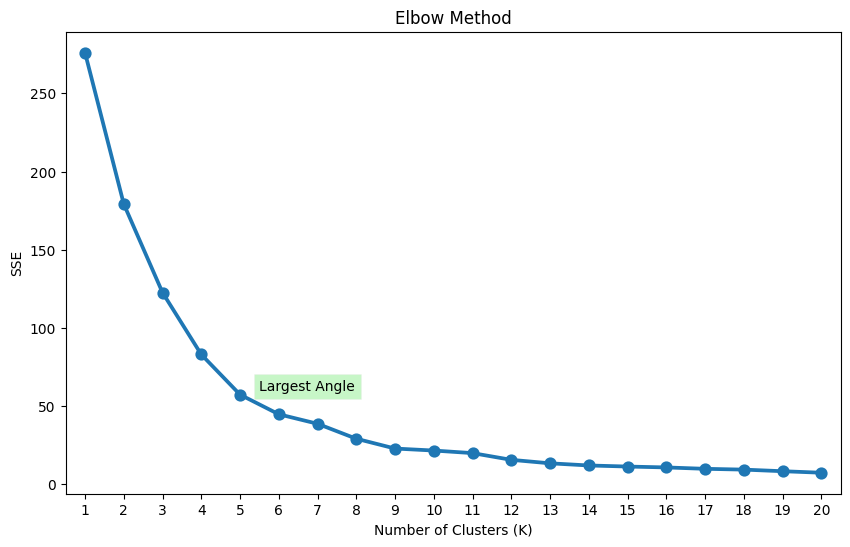

In [31]:
# Elbow Method to determine the optimal number of clusters
sse = {}
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(data_normalized)
    sse[k] = kmeans.inertia_

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE')
plt.style.use('ggplot')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.text(4.5, 60, "Largest Angle", bbox=dict(facecolor='lightgreen', alpha=0.5))
plt.show()


In [32]:
# Based on the elbow method, let's assume 5 clusters is optimal
kmeans = KMeans(n_clusters=5, random_state=1)
kmeans.fit(data_normalized)

# Assign cluster labels to the data
cluster_labels = kmeans.labels_

# Add the cluster labels to the dataframe
data_rfm = df_RFM.assign(Cluster=cluster_labels)

# Display the final dataframe with cluster labels
data_rfm.head()


,Recency,Frequency,MonetaryValue,Cluster
CUSTOMERNAME,,,,
"AV Stores, Co.",196,51,157807.81,4
Alpha Cognac,65,20,70488.44,2
Amica Models & Co.,265,26,94117.26,2
"Anna's Decorations, Ltd",84,46,153996.13,4
Atelier graphique,188,7,24179.96,1


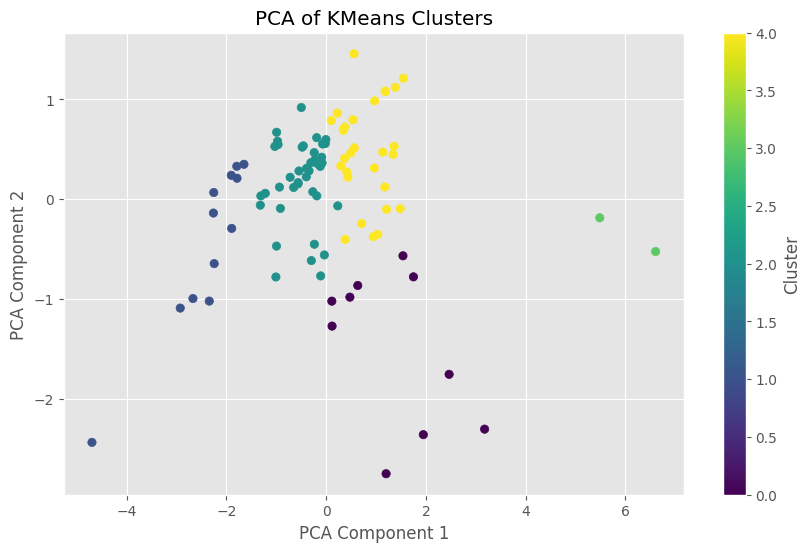

In [33]:
# Perform PCA for 2D visualization of clusters
pca = PCA(n_components=2)
pca_components = pca.fit_transform(data_normalized)

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=data_rfm['Cluster'], cmap='viridis')
plt.title('PCA of KMeans Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()


In [34]:
# Based on the elbow method, let's assume 5 clusters is optimal
kmeans = KMeans(n_clusters=5, random_state=1)
kmeans.fit(data_normalized)

# Assign cluster labels to the data
cluster_labels = kmeans.labels_

# Add the cluster labels to the dataframe
data_rfm = df_RFM.assign(Cluster=cluster_labels)

# Display the final dataframe with cluster labels
data_rfm.head()


,Recency,Frequency,MonetaryValue,Cluster
CUSTOMERNAME,,,,
"AV Stores, Co.",196,51,157807.81,4
Alpha Cognac,65,20,70488.44,2
Amica Models & Co.,265,26,94117.26,2
"Anna's Decorations, Ltd",84,46,153996.13,4
Atelier graphique,188,7,24179.96,1


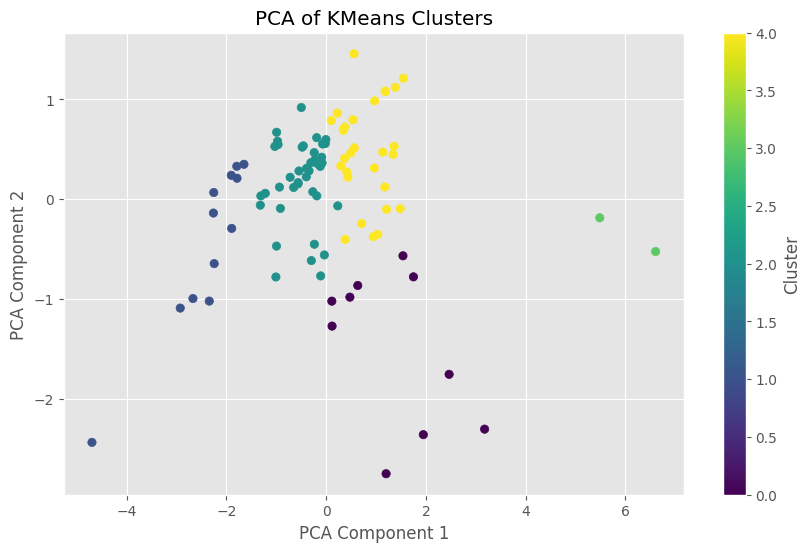

In [35]:
# Perform PCA for 2D visualization of clusters
pca = PCA(n_components=2)
pca_components = pca.fit_transform(data_normalized)

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=data_rfm['Cluster'], cmap='viridis')
plt.title('PCA of KMeans Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()


In [36]:
# Profiling each cluster: Check the mean values for each cluster
cluster_profiles = data_rfm.groupby('Cluster').mean()

# Check cluster profiles
cluster_profiles


,Recency,Frequency,MonetaryValue
Cluster,,,
0,15.200000,33.000000,114510.742000
1,324.250000,10.666667,35628.653333
2,216.725000,21.900000,78269.783000
3,2.000000,219.500000,783576.085000
4,146.571429,37.500000,134358.360714
